In [ ]:
# !pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/Users/sam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
df = pd.read_csv('../../Data/music_subset.csv')
df = df.drop('Unnamed: 0', axis=1)

In [22]:
df = df.drop('artist_name', axis=1)

In [23]:
df.columns

Index(['genre', 'track_id', 'title', 'loudness', 'tempo', 'time_signature',
       'key', 'mode', 'duration', 'avg_timbre1', 'avg_timbre2', 'avg_timbre3',
       'avg_timbre4', 'avg_timbre5', 'avg_timbre6', 'avg_timbre7',
       'avg_timbre8', 'avg_timbre9', 'avg_timbre10', 'avg_timbre11',
       'avg_timbre12', 'var_timbre1', 'var_timbre2', 'var_timbre3',
       'var_timbre4', 'var_timbre5', 'var_timbre6', 'var_timbre7',
       'var_timbre8', 'var_timbre9', 'var_timbre10', 'var_timbre11',
       'var_timbre12'],
      dtype='object')

In [26]:
X = df.drop(['genre', 'title', 'track_id'], axis=1)
y = df['genre']
x_train, y_train, x_test, y_test = train_test_split(X, y)

In [33]:
df['genre'].isnull().sum()

0

In [29]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

ValueError: Unknown label type: 'continuous-multioutput'

In [2]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    # drop the old feature from X and concat the new one-hot encoded df
    X = pd.concat([X, ohe_df], axis=1)
    return X

In [3]:
def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    return ohe, X_train_all_features

In [ ]:
ohe, df = encode_and_concat_feature_train(df, 'genre')
ohe_genres = ohe.categories_[0]

In [ ]:
df.dtypes

In [ ]:
key_dict = {0:'C', 1:'C#/Db', 2:'D', 
            3:'D#/Eb', 4:'E', 5:'F', 
            6:'F#/Gb', 7:'G', 8:'G#/Ab', 
            9:'A', 10:'A#/Bb', 11:'B'}
df['key']
genre_columns = ['classic pop and rock', 'classical', 
                 'dance and electronica', 'folk', 'hip-hop',
                'jazz and blues', 'metal', 'pop', 'punk',
                'soul and reggae']


In [ ]:
X = df.drop((['genre', 'title', 'track_id', 'artist_name']+genre_columns), axis=1)
track_ids = df['track_id']
y = df['genre']

In [ ]:
X_columns = X.columns
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X))
X.columns = X_columns
X.head()

In [ ]:
X_timbres = X.drop(['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration'], axis=1)
X_no_timbres = X.drop(X_timbres.columns, axis=1)
X_genres = df[genre_columns]
X_no_timbres = pd.concat([X_no_timbres, X_genres], sort=True, axis=1)
X_no_timbres.columns

#### pairplots w genre encoding

In [ ]:
# sns.pairplot(X_no_timbres)

#### modeling for predicting genre

In [ ]:
# this is the 'accuracy' of a model (test on our whole dataset) that would just predict a genre of classic rock for every song in the data set

df['classic pop and rock'].value_counts()[1]/df['classic pop and rock'].value_counts()[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

In [ ]:
rf.score(x_train, y_train)

In [ ]:
y.value_counts()

In [ ]:
# rf.score(x_test, y_test)
cross_val_score(rf, x_test, y_test)

In [ ]:
#create array containing dictionaries of predicted probabilities of that song being in a given genre

rf_pred_probs = rf.predict_proba(x_test)
dicts = []
for row in rf_pred_probs:
    dictionary = {}
    for k in range(len(ohe_genres)):
        dictionary[ohe_genres[k]] = row[k]
    dicts.append(dictionary)
# dicts[0:5]

In [ ]:
print(dicts[6])
print(rf.predict(x_test)[6])

In [ ]:
print(y_test.iloc[1])

In [ ]:
plot_confusion_matrix(rf, x_test, y_test)

#### modeling for predicting whether or not a song is 'classic pop and rock'

In [ ]:
df.columns

In [ ]:
# this is the 'accuracy' of a model (test on our whole dataset) that would just predict a genre of classic rock for every song in the data set
df['classic pop and rock'].value_counts()[1]/df['classic pop and rock'].value_counts()[0]

In [ ]:
X = df.drop(['genre', 'track_id', 'artist_name', 'title'], axis=1)
y = df['classic pop and rock']
X = X.drop(genre_columns, axis=1)
X.columns

In [ ]:
classic_x_train, classic_x_test, classic_y_train, classic_y_test = train_test_split(X, y)

In [ ]:
rf_classic = RandomForestClassifier()
rf_classic.fit(classic_x_train, classic_y_train)

In [ ]:
rf_classic.score(classic_x_train, classic_y_train)

In [ ]:
rf_classic.score(classic_x_test, classic_y_test)

In [ ]:
cross_val_score(rf_classic, classic_x_test, classic_y_test)

#### predicting key of release of a song

In [ ]:
df.columns

In [ ]:
X = df.drop(genre_columns, axis=1)
X = X.drop(['track_id', 'title', 'key', 'genre', 'artist_name', 'loudness', 'tempo', 'time_signature', 'mode',
       'duration'], axis=1)
y =df['key']

In [ ]:
x_train_key, x_test_key, y_train_key, y_test_key = train_test_split(X, y)

In [ ]:
rf_year = RandomForestClassifier()
rf_year.fit(x_train_key, y_train_key)

In [ ]:
cross_val_score(rf_year, x_test_key, y_test_key)

In [ ]:
np.array((df['key'].value_counts()))
df['key'].value_counts().index

In [ ]:
sns.barplot(df['key'].value_counts().index, np.array((df['key'].value_counts())))

In [ ]:
pd.read_csv('https://raw.githubusercontent.com/thomasSve/Million-Song-Dataset-Analysis/master/datasets/msd_simple.csv')

# WEDNESDAY (weighting classes)

In [40]:
df = pd.read_csv('../../Data/music_subset.csv')
df = df.drop('Unnamed: 0', axis=1).set_index('track_id')
df = df[df['genre'] != 'classic pop and rock']
df['genre'].value_counts()

folk                     13192
dance and electronica     4935
jazz and blues            4334
soul and reggae           4016
punk                      3200
metal                     2103
classical                 1874
pop                       1617
hip-hop                    434
Name: genre, dtype: int64

In [41]:
len(df.columns)

33

In [42]:
X = df.drop('genre', axis=1)
y = df['genre']

In [4]:
def get_prediction_probability_dicts(model, x_test, y_test):
    genres = y_test.value_counts().index
    model_pred_probs = model.predict_proba(x_test)
    dicts = []
    for row in model_pred_probs:
        dictionary = {}
        for k in range(len(genres)):
            dictionary[genres[k]] = row[k]
        dictionary['y actual'] = y_test[k]
        dicts.append(dictionary)
    for k in range(len(dicts)):
        dicts[k]['model prediction'] = model.predict([x_test.iloc[k]])
    return dicts

In [5]:
# function for specifically encoding artist names using OneHotEncoder

def encode_artist_name(x):
    # initiate OHE
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    # dataframe of just encoded columns, using x_train index as it's index to ensure rows line up
    ohe.fit(x[['artist_name']])
    artist_dummies = pd.DataFrame(ohe.transform(x[['artist_name']]).todense(), columns=ohe.get_feature_names(), index=x.index)
    # concat encoded columns to x
    concatted_x = pd.concat([x, artist_dummies], axis=1)
    #add column names
    concatted_x.columns = list(x.columns) + list(artist_dummies)
    concatted_x = concatted_x.drop('artist_name', axis=1)
    return concatted_x

In [45]:
# X = encode_artist_name(X)
X = X.drop(['artist_name'], axis=1)

In [46]:
# train test split with stratified target('genre')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [47]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

26778 26778 8927 8927


In [48]:
# making sure indexes still line up between x and y
pd.Series(x_train.index == y_train.index).value_counts()

True    26778
dtype: int64

In [49]:
# get rid of title column in train and test data
x_test = x_test.drop('title', axis=1)
x_train = x_train.drop('title', axis=1)

In [ ]:
# create two different models, one with class weights balanced and one with the default imbalance
rf_balanced = RandomForestClassifier(class_weight='balanced')
rf = RandomForestClassifier()

In [ ]:
rf.fit(x_train, y_train)

In [ ]:
rf_balanced.fit(x_train, y_train)

In [ ]:
print('unbalanced: ', classification_report(y_test, rf.predict(x_test)))
print('balanced: ', classification_report(y_test, rf_balanced.predict(x_test)))

In [ ]:
cross_val_score(rf, x_test, y_test)

In [ ]:
df.columns

# WEDNESDAY (SMOTE artificial sample production)

In [6]:
df = pd.read_csv('../../Data/music_subset.csv')
df = df.drop('Unnamed: 0', axis=1).set_index('track_id')
df = df[df['genre'] != 'classic pop and rock']
df['genre'].value_counts()

folk                     13192
dance and electronica     4935
jazz and blues            4334
soul and reggae           4016
punk                      3200
metal                     2103
classical                 1874
pop                       1617
hip-hop                    434
Name: genre, dtype: int64

In [7]:
X = df.drop('genre', axis=1)
y = df['genre']

In [8]:
X = encode_artist_name(X)
# X = X.drop('artist_name', axis=1)

In [9]:
# train test split with stratified target('genre')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [10]:
x_test = x_test.drop('title', axis=1)
x_train = x_train.drop('title', axis=1)

In [11]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

26778 26778 8927 8927


In [12]:
sm = SMOTE()
x_train_resamp, y_train_resamp = sm.fit_resample(x_train, y_train)

In [13]:
rf = RandomForestClassifier(n_jobs=-1, max_features=8)
rf.fit(x_train_resamp, y_train_resamp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
print(classification_report(y_train_resamp, rf.predict(x_train_resamp)))

                       precision    recall  f1-score   support

            classical       1.00      1.00      1.00      9894
dance and electronica       1.00      1.00      1.00      9894
                 folk       1.00      1.00      1.00      9894
              hip-hop       1.00      1.00      1.00      9894
       jazz and blues       1.00      1.00      1.00      9894
                metal       1.00      1.00      1.00      9894
                  pop       1.00      1.00      1.00      9894
                 punk       1.00      1.00      1.00      9894
      soul and reggae       1.00      1.00      1.00      9894

             accuracy                           1.00     89046
            macro avg       1.00      1.00      1.00     89046
         weighted avg       1.00      1.00      1.00     89046



In [15]:
print(classification_report(y_test, rf.predict(x_test)))

                       precision    recall  f1-score   support

            classical       0.82      0.91      0.86       469
dance and electronica       0.88      0.82      0.85      1234
                 folk       0.90      0.94      0.92      3298
              hip-hop       0.84      0.78      0.81       108
       jazz and blues       0.90      0.82      0.86      1084
                metal       0.93      0.96      0.94       526
                  pop       0.95      0.88      0.92       404
                 punk       0.90      0.89      0.89       800
      soul and reggae       0.89      0.89      0.89      1004

             accuracy                           0.89      8927
            macro avg       0.89      0.88      0.88      8927
         weighted avg       0.89      0.89      0.89      8927



In [54]:
cm = confusion_matrix(y_test, rf.predict(x_test), labels=y_test.unique())
cm_df = pd.DataFrame(cm, y_test.unique(), y_test.unique())

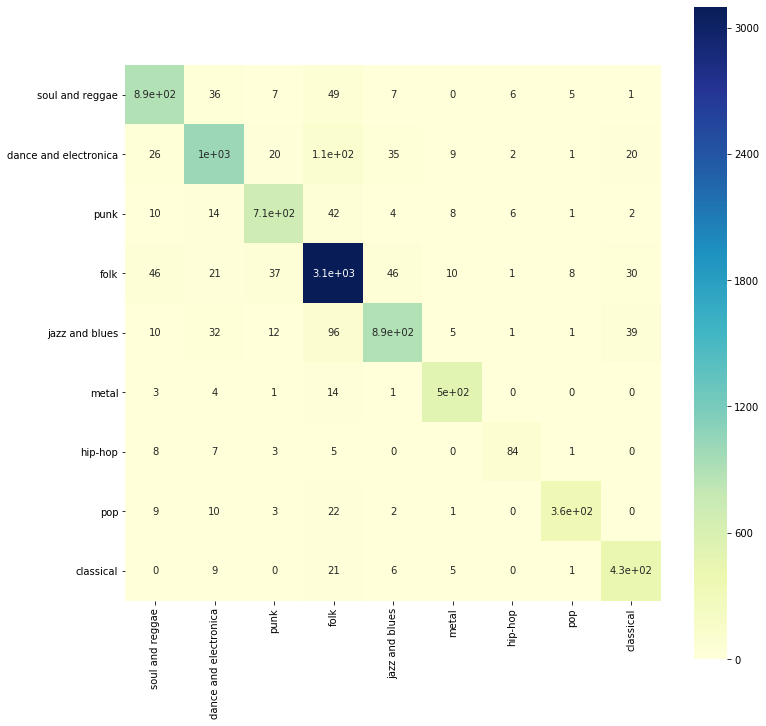

In [64]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu", ax=ax)

In [16]:
predictions = pd.DataFrame(rf.predict(x_test)).rename(columns={0: 'genre'})


In [17]:
timbres_1 = pd.DataFrame(x_test['avg_timbre1']).rename(columns={0: 'avg_timbre1'}).reset_index()


In [35]:
timbre_1_predictions = pd.concat([timbres_1, predictions], axis=1)

In [36]:
timbre_1_actual = pd.concat([x_test['avg_timbre1'], y_test], axis=1)


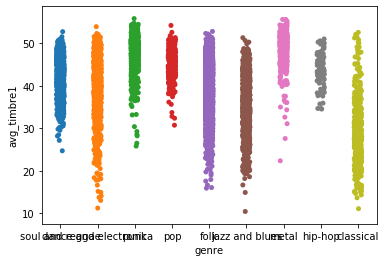

In [37]:
fig, ax1 = plt.subplots()
sns.stripplot(x='genre', y='avg_timbre1', data=timbre_1_predictions, ax = ax1)

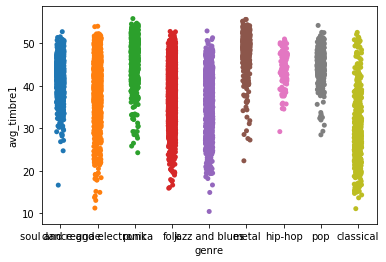

In [38]:
fig, ax2 = plt.subplots()
sns.stripplot(x='genre', y='avg_timbre1', data=timbre_1_actual, ax = ax2)

In [72]:
x= df.drop('genre', axis=1)
y=df['genre']

In [73]:
x_tr, y_tr, x_te, y_te = train_test_split(x,y)

In [74]:
train = sorted(x_tr['artist_name'].unique())
test = sorted(x_te['artist_name'].unique())

KeyError: 'artist_name'

higher score than our Random Forest Classifier using weighted classes

## hyperparameter tuning

In [25]:
rf = RandomForestClassifier(n_jobs=-1, min_samples_leaf=2, max_features=20)
rf.fit(x_train_resamp, y_train_resamp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
feat_nums = [10, 8, 6, 5]
models = []
for k in range(len(feat_nums)):
    rf = RandomForestClassifier(n_jobs=-1, max_features=feat_nums[k])
    rf.fit(x_train, y_train)
    models.append(rf)
    print(f'model for {feat_nums[k]} features trained')

In [ ]:
accuracies = []
for k in range(len(feat_nums)):
    accuracy = classification_report(y_test, models[k].predict(x_test), output_dict=True)['accuracy']
    accuracies.append(accuracy)

In [ ]:
fig, ax = plt.subplots()
ax = plt.plot(feat_nums, accuracies)


#### gridsearchCV for hyperparameter tuning (TAKES FOREVER, have yet to run all the way thorugh)

In [49]:
# criterion, min_samples_split, min_samples_leaf, max_features --->
param_grid = {'criterion': ['gini', 'entropy'], 
              'min_samples_leaf': [1,2,3],
              'max_features': ['log2', 10, 15, 20]}

In [56]:
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced', n_jobs=-1)
random_gs = GridSearchCV(rf, param_grid)

In [57]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [58]:
random_gs.fit(x_train, y_train)

KeyboardInterrupt: 

In [26]:
2+2

4

## feature exploration

In [ ]:
fig, ax = plt.subplots()
ax = sns.stripplot(x='genre', y="duration", data=df)
ax.set_xticklabels(labels=df['genre'].value_counts().index, rotation=45)